In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
# from tools_lnd import get_T_inds, plot_FP, plot_N, plot_N3D, out_axes, plot_FP_jitter, make_FP_axs, comp_eig_decomp
# from tools_lnd import make_lil_axes, same_stim_trial, generate_Beta_epoch, gen_X_from_model_dir_epoch, make_D_use
# from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir
from tools_lnd import same_mov_inds, get_interp_filename
from tools_lnd import bifurc, plot_bifurc_ends, take_names, gen_mov_trial_set, make_D_use, gen_trials_from_model_dir

In [2]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']##################

rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
ruleset = 'mem_motifs_small'
rule_trains = rules_dict[ruleset]
n_tasks = str(len(rule_trains))
rule_trains_str = '_'.join(rule_trains)
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = '0'
lr = -7
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
# net_name = 'lr7.0l2_w6.0_h-0.0_fdgo_fdanti'
data_folder = 'data/rnn/multitask/stepnet/final'
m = os.path.join(p,data_folder,ruleset,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

In [3]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v4_figs','keynote_figs','fig1','fig1_two_task_bifurc')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [4]:
# model = Model(m)
# with tf.Session() as sess:
#     model.restore()
#     model._sigma=0
#     var_list = model.var_list
#     params = [sess.run(var) for var in var_list]
#     hparams = model.hp
#     trial = generate_trials('delaygo', hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
#     feed_dict = tools.gen_feed_dict(model, trial, hparams)
#     h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
#     n_input = hparams['n_input']
#     n_rnn = hparams['n_rnn']
#     n_output = hparams['n_output']
#     w_in = params[0]
#     b_in = params[1]
#     w_out = params[2]
#     b_out = params[3]
#     sigma_rec = 0#hparams['sigma_rec']
#     dt = hparams['dt']
#     tau = hparams['tau']
#     alpha = dt/tau
#     activation = hparams['activation']


In [5]:
# def plot_N(X, D, clist, linewidth = 1, alpha = .5, linestyle = '-', cmap_c = 'hsv',markersize = 10):
#     """Plot activity is some 2D space.

#         Args:
#             X: neural activity in Trials x Time x Neurons
#             D: Neurons x 2 plotting dims
#         """

#     cmap=plt.get_cmap(cmap_c)
#     S = np.shape(X)[0]
    
#     for s in range(S):

#         if len(clist)==1:
#             c = clist[0]
#         else:
#             c = cmap(clist[s]/max(clist))

#         X_trial = np.dot(X[s,:,:],D.T)
#         plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, linewidth = linewidth, alpha = alpha, markersize = markersize,
#                 markeredgewidth = linewidth)
#         plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, linewidth = linewidth, alpha = alpha, markersize = markersize)
#         plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, linewidth = linewidth, alpha = alpha,markersize = markersize,
#                  markeredgewidth = linewidth)

In [6]:
# from tools_lnd import take_names
# offset = 0
# t_set = [offset, offset]
# trial_num = [int(offset/4), int(offset/4)]
# fig_size = 4
# cmap_discrete = ['w','k']

In [7]:
# fig = plt.figure(figsize=(14, 5))
# cmap=plt.get_cmap('Greys')
# fname = os.path.join(m, 'log.json')
# task_list = hparams['rule_trains']

# with open(fname, 'r') as f:
#     log_all = json.load(f)
# for r in range(len(task_list)):
#     c = cmap((r+1)/(len(task_list)+1))
    
#     ax1 = fig.add_subplot(1,1,1)
#     x = np.log(log_all['cost_'+task_list[r]])
#     plt.plot(x,'-',c = c,alpha = .5)

#     ax2 = fig.add_subplot(1,2,2)
#     x = log_all['perf_'+task_list[r]]
#     plt.plot(x,'-',c = c,alpha = .5)

# ax1.set_xlabel('Training Step (x 1000)')
# ax1.set_ylabel('Log Cost [for each task]')    
# ax2.set_xlabel('Training Step (x 1000)')
# ax2.set_ylabel('Performance [for each task]')
# plt.title(m)
# plt.show()    

In [8]:
# %matplotlib notebook

In [12]:
q_thresh = 1e-8
offset = 0
t_set = [offset, offset]
trial_num = [int(offset/4), int(offset/4)]
rule_axs = 0
rule_set = [5,2]
trial_set = gen_mov_trial_set(m,rule_set)
epoch_set = ['fix1','fix1']
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
ti = trial_num[rule_axs]

rule1 = rules_dict['all'][rule_set[0]]
rule2 = rules_dict['all'][rule_set[1]]
rule_str = [rule1,rule2]

ax_labels = 'pca_h'
D_fix = make_D_use(m,rule,'fix1',ti,ax_labels)
D_use = D_fix

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[rule_axs],rules_dict['all'][rule_set[rule_axs]])
ax_labels_master = [r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC1',
                    r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC2',
                    r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC3']

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0'

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

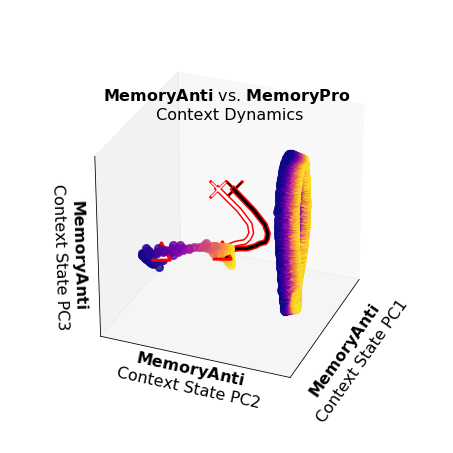

In [24]:
from tools_lnd import make_D_use, interp3d, take_names

q_thresh = 1e-7
interp = True
fig_size = 5
script_name = 'interp_tasks_small_init_stim'
epoch_set = ['fix1','fix1']

fig_size = 6
fontsize = 18
n_trials = 8

ax_labels = ax_labels_master

bifurc(m, D_use, rule_set, epoch_set, script_name = script_name,
         q_thresh = q_thresh, rule_axs = rule_axs, plot_unstable = True, title_y = .8,
         n_skip_interps=1, color_stim = True, fig_size = fig_size, fontsize = 16,
         figpath = figpath, ruleset = ruleset, al_fp = .8,ax_labels = ax_labels, stability_thresh = 1.05,
          view_ang = [29,-158],bifurc = False)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

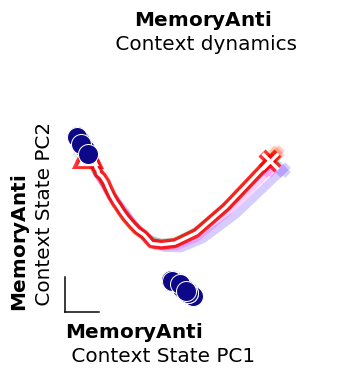

k
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=

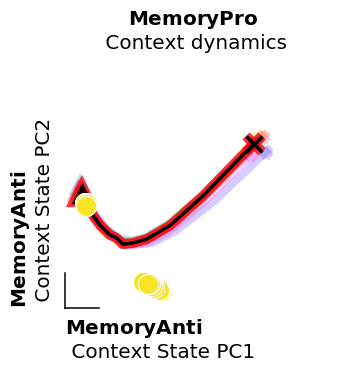

In [23]:
interp = True
fig_size = 6

epoch_set = ['fix1','fix1']
script_name = 'interp_tasks_small_init_stim'

ax_use = [0,1,2]
D_rotate = D_use[:,ax_use]
ax_labels = [ax_labels_master[alm] for alm in ax_use]

ax_labels[2] = ax_labels_master[1] 
ax_labels[1] = ax_labels_master[0] 
ax_labels[0] = r"Rule Input $\alpha$"

# bifurc(m,D_rotate,rule_set,epoch_set,script_name = script_name,q_thresh = q_thresh, rule_axs = rule_axs, 
#        color_stim = True, fig_size = fig_size,fontsize = 16, figpath = figpath, ruleset = ruleset,
#        ax_labels = ax_labels, stability_thresh = 1.05, lims = [])

plot_bifurc_ends(m, D_rotate, rule_set, epoch_set, script_name, lims = [], fac_mult_lims = 2,
                 stability_thresh = 1.05, fp_first = False, figpath = figpath, ruleset = ruleset,
                ax_labels = [ax_labels[1],ax_labels[2]])

In [13]:
# from tools
tol_q = 1e-6
script_name = 'interp_tasks_small_init_mov'
epoch_set = ['delay1','delay1']
trial1 = gen_trials_from_model_dir(m,rule_str[0],mode='test',noise_on = False)
trial2 = gen_trials_from_model_dir(m,rule_str[1],mode='test',noise_on = False)
trial2 = same_mov_inds(trial1, trial2) 
trial1 = gen_trials_from_model_dir(m,rule_str[0],mode='test',noise_on = False)
save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))
filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)
        
fp_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)),
                      filename_interp+'_step_'+str(0)+'.npz')
fp_struct = np.load(fp_dir)
sorted_fps = fp_struct['xstar']

pca = PCA(n_components = 3)
fp_pca = pca.fit_transform(sorted_fps)
D_use = pca.components_.T
ax_labels = 'pca_fp'

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[rule_axs],rules_dict['all'][rule_set[rule_axs]])
ax_labels_master = [r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC1',
            r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC2',
            r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC3',]

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


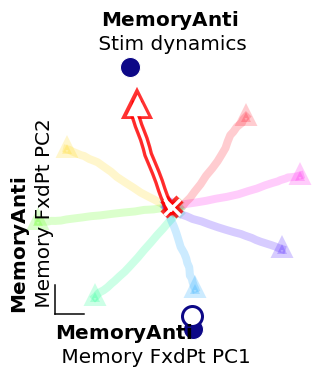

k
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=

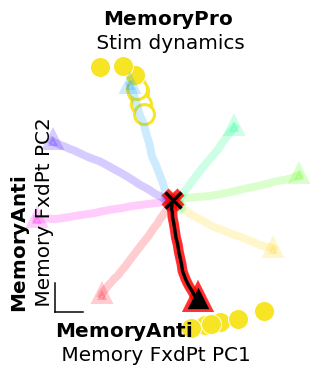

In [14]:
from tools_lnd import make_D_use, interp3d, take_names

fig_size = 4
q_thresh = .00001
interp = True
epoch_set = ['stim1','stim1']
script_name = 'interp_tasks_small_init_stim'

ax_use = [0,1,2]
D_rotate = D_use[:,ax_use]
ax_labels = [ax_labels_master[alm] for alm in ax_use]

ax_labels[0] = r"Rule Input $\alpha$"

# bifurc(m,D_rotate,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
#        q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .95,
#        n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16,
#        figpath = figpath,ruleset = ruleset,ax_labels = ax_labels,
#        stability_thresh = 1, lims = [], threeD = False)

ax_use = [1,0,2]
D_rotate = D_use[:,ax_use]
ax_labels = [ax_labels_master[alm] for alm in ax_use]

plot_bifurc_ends(m,D_rotate,rule_set,epoch_set,script_name, lims = [],q_thresh = q_thresh,
                 figpath = figpath, ruleset = ruleset,ax_labels = [ax_labels_master[0],ax_labels_master[1]])

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

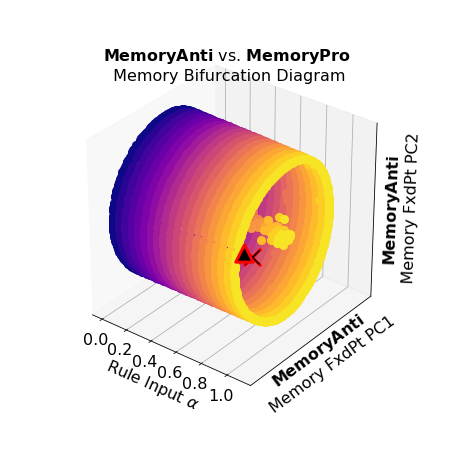

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

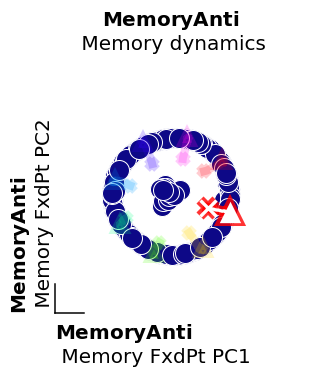

k
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=

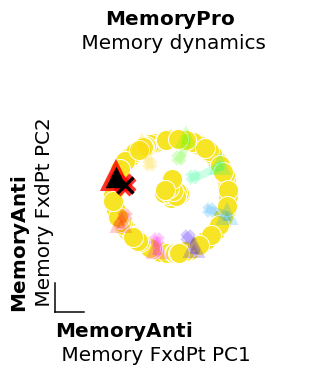

In [13]:
fig_size = 6
epoch_set = ['delay1','delay1']
script_name = 'interp_tasks_small_init_mov'

ax_labels = {}
ax_labels[1] = ax_labels_master[0]
ax_labels[2] = ax_labels_master[1]
ax_labels[0] = r"Rule Input $\alpha$"

q_thresh = .0001

lims = bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1.05, 
              lims = [], view_ang = [31,-52])

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [], fac_mult_lims = 2, q_thresh = q_thresh,
                 stability_thresh = 1.05,color_stim = True, figpath = figpath, ruleset = ruleset,
                ax_labels = [ax_labels[1],ax_labels[2]])

In [10]:
tol_q = 1e-6
script_name = 'interp_tasks_small_init_mov'
epoch_set = ['go1','go1']
trial1 = gen_trials_from_model_dir(m,rule_str[0],mode='test',noise_on = False)
trial2 = gen_trials_from_model_dir(m,rule_str[1],mode='test',noise_on = False)
trial2 = same_mov_inds(trial1, trial2) 
trial1 = gen_trials_from_model_dir(m,rule_str[0],mode='test',noise_on = False)
save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))
filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)
        
fp_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)),
                      filename_interp+'_step_'+str(0)+'.npz')
fp_struct = np.load(fp_dir)
sorted_fps = fp_struct['xstar']

pca = PCA(n_components = 3)
fp_pca = pca.fit_transform(sorted_fps)
D_use = pca.components_.T
ax_labels = 'pca_fp'

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[rule_axs],rules_dict['all'][rule_set[rule_axs]])
ax_labels_master = [r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC1',
            r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC2',
            r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC3',]

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

In [32]:
from tools_lnd import same_stim_trial, load_fps_from_interp, plot_FPs, gen_X_from_model_dir, get_T_inds, plot_N, make_lil_axes
def plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name,tol_q = 1e-6,t_set = [0,0],
                     q_thresh = .0000001,fig_size = 4, lims = [], fac_mult_lims = 1.5,
                     stability_thresh = 1,fp_first = True, color_stim = True, step_set = [0,19],
                     figpath = 'plot_bifurc_ends',ruleset = 'all',fontsize = 20, 
                     plot_unstable = True,plot_expansion = False,ax_labels = []):
    
    cmap_discrete = ['w','k']
    cmap_grad = plt.get_cmap('plasma')

    rule1 = rules_dict['all'][rule_set[0]]
    rule2 = rules_dict['all'][rule_set[1]]
    rule_str = [rule1,rule2]

    if color_stim:
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
        trial2 = same_stim_trial(trial1, rule_set[1]) 
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    else:
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
        trial2 = gen_trials_from_model_dir(m,rule2,mode='test',noise_on = False)
        trial2 = same_mov_inds(trial1, trial2) 
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

    save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))

    filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)
    trial_set = [trial1, trial2]

    trial_inds = range(0,np.shape(trial1.x)[1],int(np.shape(trial1.x)[1]/8))

    for ri in [0,1]:
        fig = plt.figure(figsize=(fig_size,fig_size),tight_layout=True,facecolor='white')
        ax = fig.add_axes([0,0,1,1])

        sorted_fps, eig_decomps = load_fps_from_interp(m,script_name,rule_str,tol_q,filename_interp,
                                                         step_set[ri],q_thresh)

        if fp_first:
            plot_FPs(ax,sorted_fps, eig_decomps, D_use, step_set[ri], 
                stability_thresh = stability_thresh, plot_unstable = plot_unstable,
                plot_expansion = plot_expansion)
        
        rule = rule_str[ri]
        epoch = epoch_set[ri]
        c_master = cmap_discrete[ri]
        print(c_master)

        trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)

        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch_set[ri])
        T_inds_plot = range(np.max([T_inds[0]-1,0]),T_inds[-1])
        x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))


        cmap_state = plt.get_cmap('hsv')
        if color_stim:
            c_set = np.min(trial.stim_locs[:,[0,2]],axis = 1)
            s = np.argwhere(c_set == np.min(trial1.stim_locs[t_set[0],[0,2]]))[0][0]
            c = cmap_state(c_set[s]/(2*np.pi))
        else:
            c_set = trial.y_loc[-1,:]
            s = np.argwhere(c_set==trial1.y_loc[-1,t_set[0]])[0][0]
            c = cmap_state(c_set[s]/(2*np.pi))

        lw = 10
        plot_N(x_epoch[trial_inds,:,:], D_use.T, c_set[trial_inds], linewidth = fig_size*2, alpha = .2)
        plot_N(x_epoch[[s,],:,:], D_use.T, c, linewidth = lw, alpha = .8 ,markersize = 16)
        plot_N(x_epoch[[s,],:,:], D_use.T, c_master, linewidth = lw/3, alpha = 1 ,markersize = 16)

        if not fp_first:
            plot_FPs(ax,sorted_fps, eig_decomps, D_use, step_set[ri], 
                stability_thresh = stability_thresh, plot_unstable = plot_unstable,
                plot_expansion = plot_expansion)

        if len(lims)>0:
            ax.set_xlim([fac_mult_lims*lims[0],fac_mult_lims*lims[1]])
            ax.set_ylim([fac_mult_lims*lims[2],fac_mult_lims*lims[3]])
        else:
            # [x1,x2] = ax.get_xlim()
            # [y1,y2] = ax.get_ylim()
            # ax.set_xlim([x1-.2*abs(x1),x2+.2*abs(x2)])
            # ax.set_ylim([y1-.2*abs(y1),y2+.2*abs(y2)])
            
            ax.set_ylim([-1.15,1.15])
            ax.set_xlim([-1.15,1.15])

        epoch_name, rule_name, _, _ = take_names(epoch_set[ri],rule_str[ri])
        
        ax.set_ylim([-1.2,1.2])
        ax.set_xlim([-1.2,1.2])
        
        if len(ax_labels)>0:
            make_lil_axes(ax,ax_labels)

        ax.set_ylim([-1.2,1.2])
        ax.set_xlim([-1.2,1.2])

        tit = r"$\bf{"+rule_name+"}$"+'\n '+epoch_name+' dynamics'
        tit_name = rule_name+'_'+epoch_name+'_dynamics'
        plt.title(tit,fontsize = fontsize)#,y = .9
        fig_fldr = os.path.join(figpath,'interp_fps',ruleset,'bifurcation')
        if not os.path.exists(fig_fldr):
            os.makedirs(fig_fldr)

        plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
        plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
        plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3

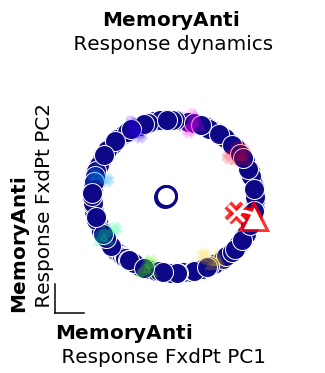

k
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/mem_motifs_small/LeakyRNN/softplus/diag/2_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo_delayanti/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=

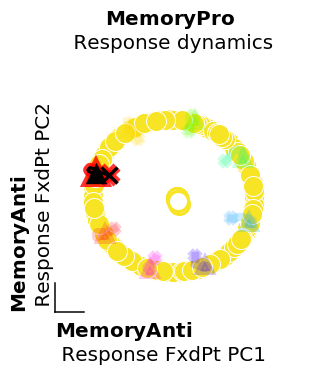

In [33]:
D_use = np.zeros((256,3))

fig_size = 6
q_thresh = .1
epoch_set = ['go1','go1']
script_name = 'interp_tasks_small_init_mov'

filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)
fp_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)),
                      filename_interp+'_step_'+str(0)+'.npz')

fp_struct = np.load(fp_dir)
sorted_fps = fp_struct['xstar']

pca = PCA(n_components = 3)
fp_pca = pca.fit_transform(sorted_fps)
D_use = pca.components_.T
D_use[:,0] = -D_use[:,0]

# lims = bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
#          q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,
#          n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16,
#          figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 2, 
#                        lims = [], view_ang = [31,-52])

lim_fac = 2

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2, q_thresh = q_thresh,
                 stability_thresh = 1.05, color_stim = True, figpath = figpath, ruleset = ruleset,
                ax_labels = [ax_labels_master[0],ax_labels_master[1]])

In [ ]:
def plot_stim_angles(ax,stim_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = True, two_task = False, show_rainbow = True):
        
    stim_cmap = plt.get_cmap('hsv')

    [x1,x2] = ax.get_xlim()
    x_diff = (x2-x1)/10
    [y1,y2] = ax.get_ylim()
    y_diff = (y2-y1)/10
    
    x_origin = x1+5*x_diff
    y_origin = y2+y_diff

    if show_rainbow:
        for theta in stim_locs:
            c = stim_cmap(theta/(2*np.pi))
            plt.plot([x_origin,x_origin+x_diff*np.cos(theta)],
                     [y_origin,y_origin+y_diff*np.sin(theta)],'-',c = c,alpha = .5,linewidth = 5)
        
        if show_stim:
            plt.text(x_origin+x_diff*np.cos(np.pi)*1.2,y_origin+y_diff*np.sin(np.pi/2)/4,
                     'Stimulus '+r'$\theta$',fontsize = 16,fontweight ='bold')
        else:
            plt.text(x_origin+x_diff*np.cos(np.pi)*1.4,y_origin+y_diff*np.sin(np.pi/2)/4,
                     'Response '+r'$\theta$',fontsize = 16,fontweight ='bold')
    
    
    if cat_task:
        plt.text(x_origin+x_diff*np.cos(0),y_origin-y_diff*np.sin(np.pi/2),'Category \n Boundary',fontsize = 14)
        plt.plot([x_origin-x_diff*np.cos(np.pi),x_origin+x_diff*np.cos(np.pi)],
                 [y_origin-y_diff*np.sin(np.pi),y_origin+y_diff*np.sin(np.pi)],':k',alpha = .9,linewidth = 3)
        
    if two_task:
        plt.plot([x_origin,x_origin+x_diff/2],[y_origin+3.5*y_diff,y_origin+3.5*y_diff],
                 '-',c = cmap_discrete[1],alpha = .9,linewidth = 6)
        plt.scatter(x_origin,y_origin+3.5*y_diff,marker = 'x',c = cmap_discrete[1],alpha = .9,s = 150,linewidth = 4)
        plt.text(x_origin+x_diff,y_origin+3.5*y_diff,'Task1',fontsize = 14,verticalalignment='center',fontweight ='bold')
        plt.scatter(x_origin+x_diff/2,y_origin+3.5*y_diff,marker = '^',c = cmap_discrete[1],alpha = .9,s = 80,linewidth = 4)
        
        plt.plot([x_origin,x_origin+x_diff/2],[y_origin+2.5*y_diff,y_origin+2.5*y_diff],
                 '-',c = cmap_discrete[0],alpha = .9,linewidth = 6)
        plt.scatter(x_origin,y_origin+2.5*y_diff,marker = 'x',c = cmap_discrete[0],alpha = .9,s = 150,linewidth = 4)
        plt.scatter(x_origin+x_diff/2,y_origin+2.5*y_diff,marker = '^',c = cmap_discrete[0],alpha = .9,s = 80,linewidth = 4)
        plt.text(x_origin+x_diff,y_origin+2.5*y_diff,'Task2',fontsize = 14,verticalalignment='center',fontweight ='bold')
        
    remove_ax_lines(ax)
    ax.set_xticks([])
    ax.set_yticks([])


In [ ]:
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(.4,.5),tight_layout=True,facecolor='white')
ax2 = fig.add_axes([0, 0, 1, 1])
stim1_locs = np.min(trial.stim_locs[0:-1:10,[0,2]],axis=1) #only workds for single modality tasks
plot_stim_angles(ax2,stim1_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = False, two_task = True, show_rainbow = False)

figname = 'task_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'task_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()

In [ ]:
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(1,1),tight_layout=True,facecolor='white')
ax2 = fig.add_axes([0, 0, 1, 1])
plot_stim_angles(ax2,stim1_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = True, two_task = False)

figname = 'stim_angle_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'stim_angle_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()

In [ ]:
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(1,1),tight_layout=True,facecolor='white')
ax2 = fig.add_axes([0, 0, 1, 1])
plot_stim_angles(ax2,stim1_locs,linewidth = 10, alpha = .9, markersize = 10,
                cat_task = False, show_stim = False, two_task = False)

figname = 'response_angle_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'response_angle_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()

In [ ]:
def interp_legend(ax,linewidth = 10, al = .9, markersize = 10,n_interp = 20,n_skip_interps = 2):
    cmap = plt.get_cmap('plasma')
    for step_i in range(0,n_interp,n_skip_interps):
        c = cmap(step_i/n_interp)
        ax.scatter(step_i-21.5,0,s = 200,marker = 'o',edgecolors = c,facecolors = c,alpha = al)
    plt.text(-n_interp-3,-.06,'DelayPro ---> DelayAnti',fontsize = 14,fontweight ='bold')
    plt.text(-2*n_interp-4,-.06,'Rule Input Interpolation \n   Stable Fixed Points:',fontsize = 14,fontweight ='bold')
        
    remove_ax_lines(ax)
    ax.set_xticks([])
    ax.set_yticks([])
#     [x1,x2] = ax.get_xlim()
#     [y1,y2] = ax.get_ylim()
#     ax.set_xlim([y1-3,y2])
    
from tools_lnd import remove_ax_lines
fig = plt.figure(figsize=(2.6,1),tight_layout=True,facecolor='white')
ax = fig.add_axes([0, 0, 1, 1])
interp_legend(ax,linewidth = 10, al = .9, markersize = 10,n_interp = 20)

figname = 'interp_legend.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname),bbox_inches='tight')

figname = 'interp_legend.png'
plt.savefig(os.path.join(figpath,figname))
plt.show()